## Plot GWAS enrichment results

In [18]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp

import plotnine as p9
import sys
from pathlib import Path
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt

In [19]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [20]:
sc.set_figure_params()

In [21]:
sys.path.append(str(Path.home() / 'Code/sctoolkit')) ## available at https://github.com/gokceneraslan/sctoolkit

In [22]:
from sctoolkit.modules import find_modules, tag_with_score, sort_module_dict
from sctoolkit.mgsa import get_go_gaf, mgsa, plot_mgsa, plot_mgsa_diagnostics
from sctoolkit.utils import sort_by_correlation

In [23]:
ad = sc.read('adata.h5ad')

## Load GWAS genes

In [24]:
gwas_ad = sc.read('otg-gwascat-20210125.h5ad')
gwas_ad

AnnData object with n_obs × n_vars = 5674 × 12864
    obs: 'studyId', 'pmid', 'pubAuthor', 'pubDate', 'pubJournal', 'pubTitle', 'traitReported', 'ancestryInitial', 'gene_id', 'gene_symbol', 'nInitial', 'numAssocLoci', 'source', 'traitEfos', 'hasSumsStats', 'ancestryReplication', 'nReplication', 'nCases', 'nTotal', 'traitCategory', 'traitEfosStr'
    var: 'gene_id'

In [ ]:
gwas_df = gwas_ad.obs[gwas_ad.obs.source=='otg'].copy()
gwas_df.traitReported.cat.remove_unused_categories(inplace=True)
#gwas_df = gwas_df.loc[gwas_df.groupby('traitReported')['numAssocLoci'].idxmax()].copy()
gwas_df.traitReported = gwas_df.traitReported.str.replace('Neurociticism', 'Neuroticism')
gwas_df = gwas_df.loc[gwas_df.groupby('traitReported')['nTotal'].idxmax()].copy()

In [28]:
pd.options.display.max_rows = 100

In [29]:
df_dict = {}

In [30]:
from statsmodels.stats.multitest import multipletests

## Plot enrichments for all tissues

In [ ]:
enrich_df = []
for t in tqdm(['breast', 'esophagusmuscularis', 'esophagusmucosa', 'heart', 'lung', 'prostate', 'skin', 'skeletalmuscle']):
    enrich = pd.read_pickle(f'modules-{t}-enrichment-v2.pkl')
    enrich = enrich[~((enrich.tissue == 'heart') & (enrich.category=='Unknown (NRG1-NRG3)'))]
    enrich = enrich[(enrich.zscore>1.) & (enrich.gwas.isin(gwas_df.index))]    
    sig, qval, _, _ = multipletests(enrich.pval, method='fdr_bh', alpha=0.05)
    enrich['fdr_significant'] = sig
    enrich['final_score'] = enrich.fscore * enrich.score
    enrich['fdr'] = qval
    enrich['significant_expressed'] = (enrich.precision>=0.05) & (enrich.pospos>3) & (enrich.fdr<0.05) & (enrich.final_score>0.15) # high precision prioritizes better module overlap    
    enrich['category'] = enrich.category.str.replace('NMJ', 'Myocyte (NMJ-rich)')    
    enrich['category'].loc[(enrich.tissue == 'heart') & (enrich.category == 'Unknown')] = 'Endothelial (cardiac microvascular)'
    enrich['celltypetissue'] = enrich['category'].astype(str) + "|" + enrich['tissue'].astype(str)
    enrich['levelmodule'] = enrich['level'].astype(str) + "|" + enrich['module'].astype(str)
    enrich_df.append(enrich)
    
enrich = pd.concat(enrich_df, axis=0).reset_index(drop=True)
enrich['gwas_id'] = enrich['gwas']
enrich['gwas'] = [x.split('_')[-1] for x in enrich.gwas]
#enrich = enrich.loc[enrich.groupby(['gwas_id', 'celltypetissue'])['final_score'].idxmax()].sort_values('final_score').reset_index(drop=True).copy()

In [32]:
enrich['Tissue'] = enrich.tissue.map({'breast': 'Breast', 'esophagusmuscularis': 'E. muscularis', 'esophagusmucosa': 'E. mucosa', 'heart': 'Heart', 'lung': 'Lung', 'prostate': 'Prostate', 'skeletalmuscle': 'Sk. muscle', 'skin': 'Skin'})

In [33]:
enrich

,gwas,level,module,pval,logOR,pospos,posneg,negpos,negneg,precision,...,zscore,tissue,fdr_significant,final_score,fdr,significant_expressed,celltypetissue,levelmodule,gwas_id,Tissue
0,"Lipid metabolism phenotypes [HDL.large, whole]",level_2,29,0.036363,5.337315,1,2,218,17627,0.004566,...,1.027333,breast,False,0.055237,0.082051,False,Endothelial cell (lymphatic)|breast,level_2|29,GCST000533_10_Lipid metabolism phenotypes [HDL...,Breast
1,"Lipid metabolism phenotypes [HDL-C.assay, fast...",level_2,29,0.048189,4.752271,1,3,218,17626,0.004566,...,1.027333,breast,False,0.054989,0.095485,False,Endothelial cell (lymphatic)|breast,level_2|29,GCST000533_5_Lipid metabolism phenotypes [HDL-...,Breast
2,"Lipid metabolism phenotypes [HDL-C.assay, whole]",level_2,29,0.036363,5.337315,1,2,218,17627,0.004566,...,1.027333,breast,False,0.055237,0.082051,False,Endothelial cell (lymphatic)|breast,level_2|29,GCST000533_6_Lipid metabolism phenotypes [HDL-...,Breast
3,"Lipid metabolism phenotypes [HDL-C.by.NMR, fas...",level_2,29,0.036363,5.337315,1,2,218,17627,0.004566,...,1.027333,breast,False,0.055237,0.082051,False,Endothelial cell (lymphatic)|breast,level_2|29,GCST000533_7_Lipid metabolism phenotypes [HDL-...,Breast
4,"Lipid metabolism phenotypes [HDL-C.by.NMR, whole]",level_2,29,0.036363,5.337315,1,2,218,17627,0.004566,...,1.027333,breast,False,0.055237,0.082051,False,Endothelial cell (lymphatic)|breast,level_2|29,GCST000533_8_Lipid metabolism phenotypes [HDL-...,Breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556546,Immature reticulocyte fraction,level_99,2100,0.088719,3.684923,1,279,5,17941,0.166667,...,3.213806,skeletalmuscle,False,0.037692,0.168959,False,Immune (NK cell)|skeletalmuscle,level_99|2100,NEALE2_30280_raw_Immature reticulocyte fraction,Sk. muscle
556547,Immature reticulocyte fraction,level_99,2100,0.088719,3.684923,1,279,5,17941,0.166667,...,2.627825,skeletalmuscle,False,0.031616,0.168959,False,Immune (NK cell)|skeletalmuscle,level_99|2100,NEALE2_30280_raw_Immature reticulocyte fraction,Sk. muscle
556548,"Pulse rate, automated reading",level_99,3086,0.042670,5.099157,1,262,2,17961,0.333333,...,1.110028,skeletalmuscle,False,0.011439,0.116239,False,Endothelial cell (vascular) III|skeletalmuscle,level_99|3086,"NEALE2_102_raw_Pulse rate, automated reading",Sk. muscle
556549,Arthrotec tablet | treatment/medication code,level_99,3086,0.000494,12.153315,1,2,2,18221,0.333333,...,1.110028,skeletalmuscle,True,0.507125,0.024998,False,Endothelial cell (vascular) III|skeletalmuscle,level_99|3086,NEALE2_20003_1140871266_Arthrotec tablet | tre...,Sk. muscle


In [34]:
pd.options.display.max_columns = None

## Plot all

In [38]:
sc.settings.figdir = 'figures'

In [58]:
width_scales = df.groupby('tissue')['category'].nunique().values

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 28 x 28.9811320754717 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/SFigure-6-1.pdf


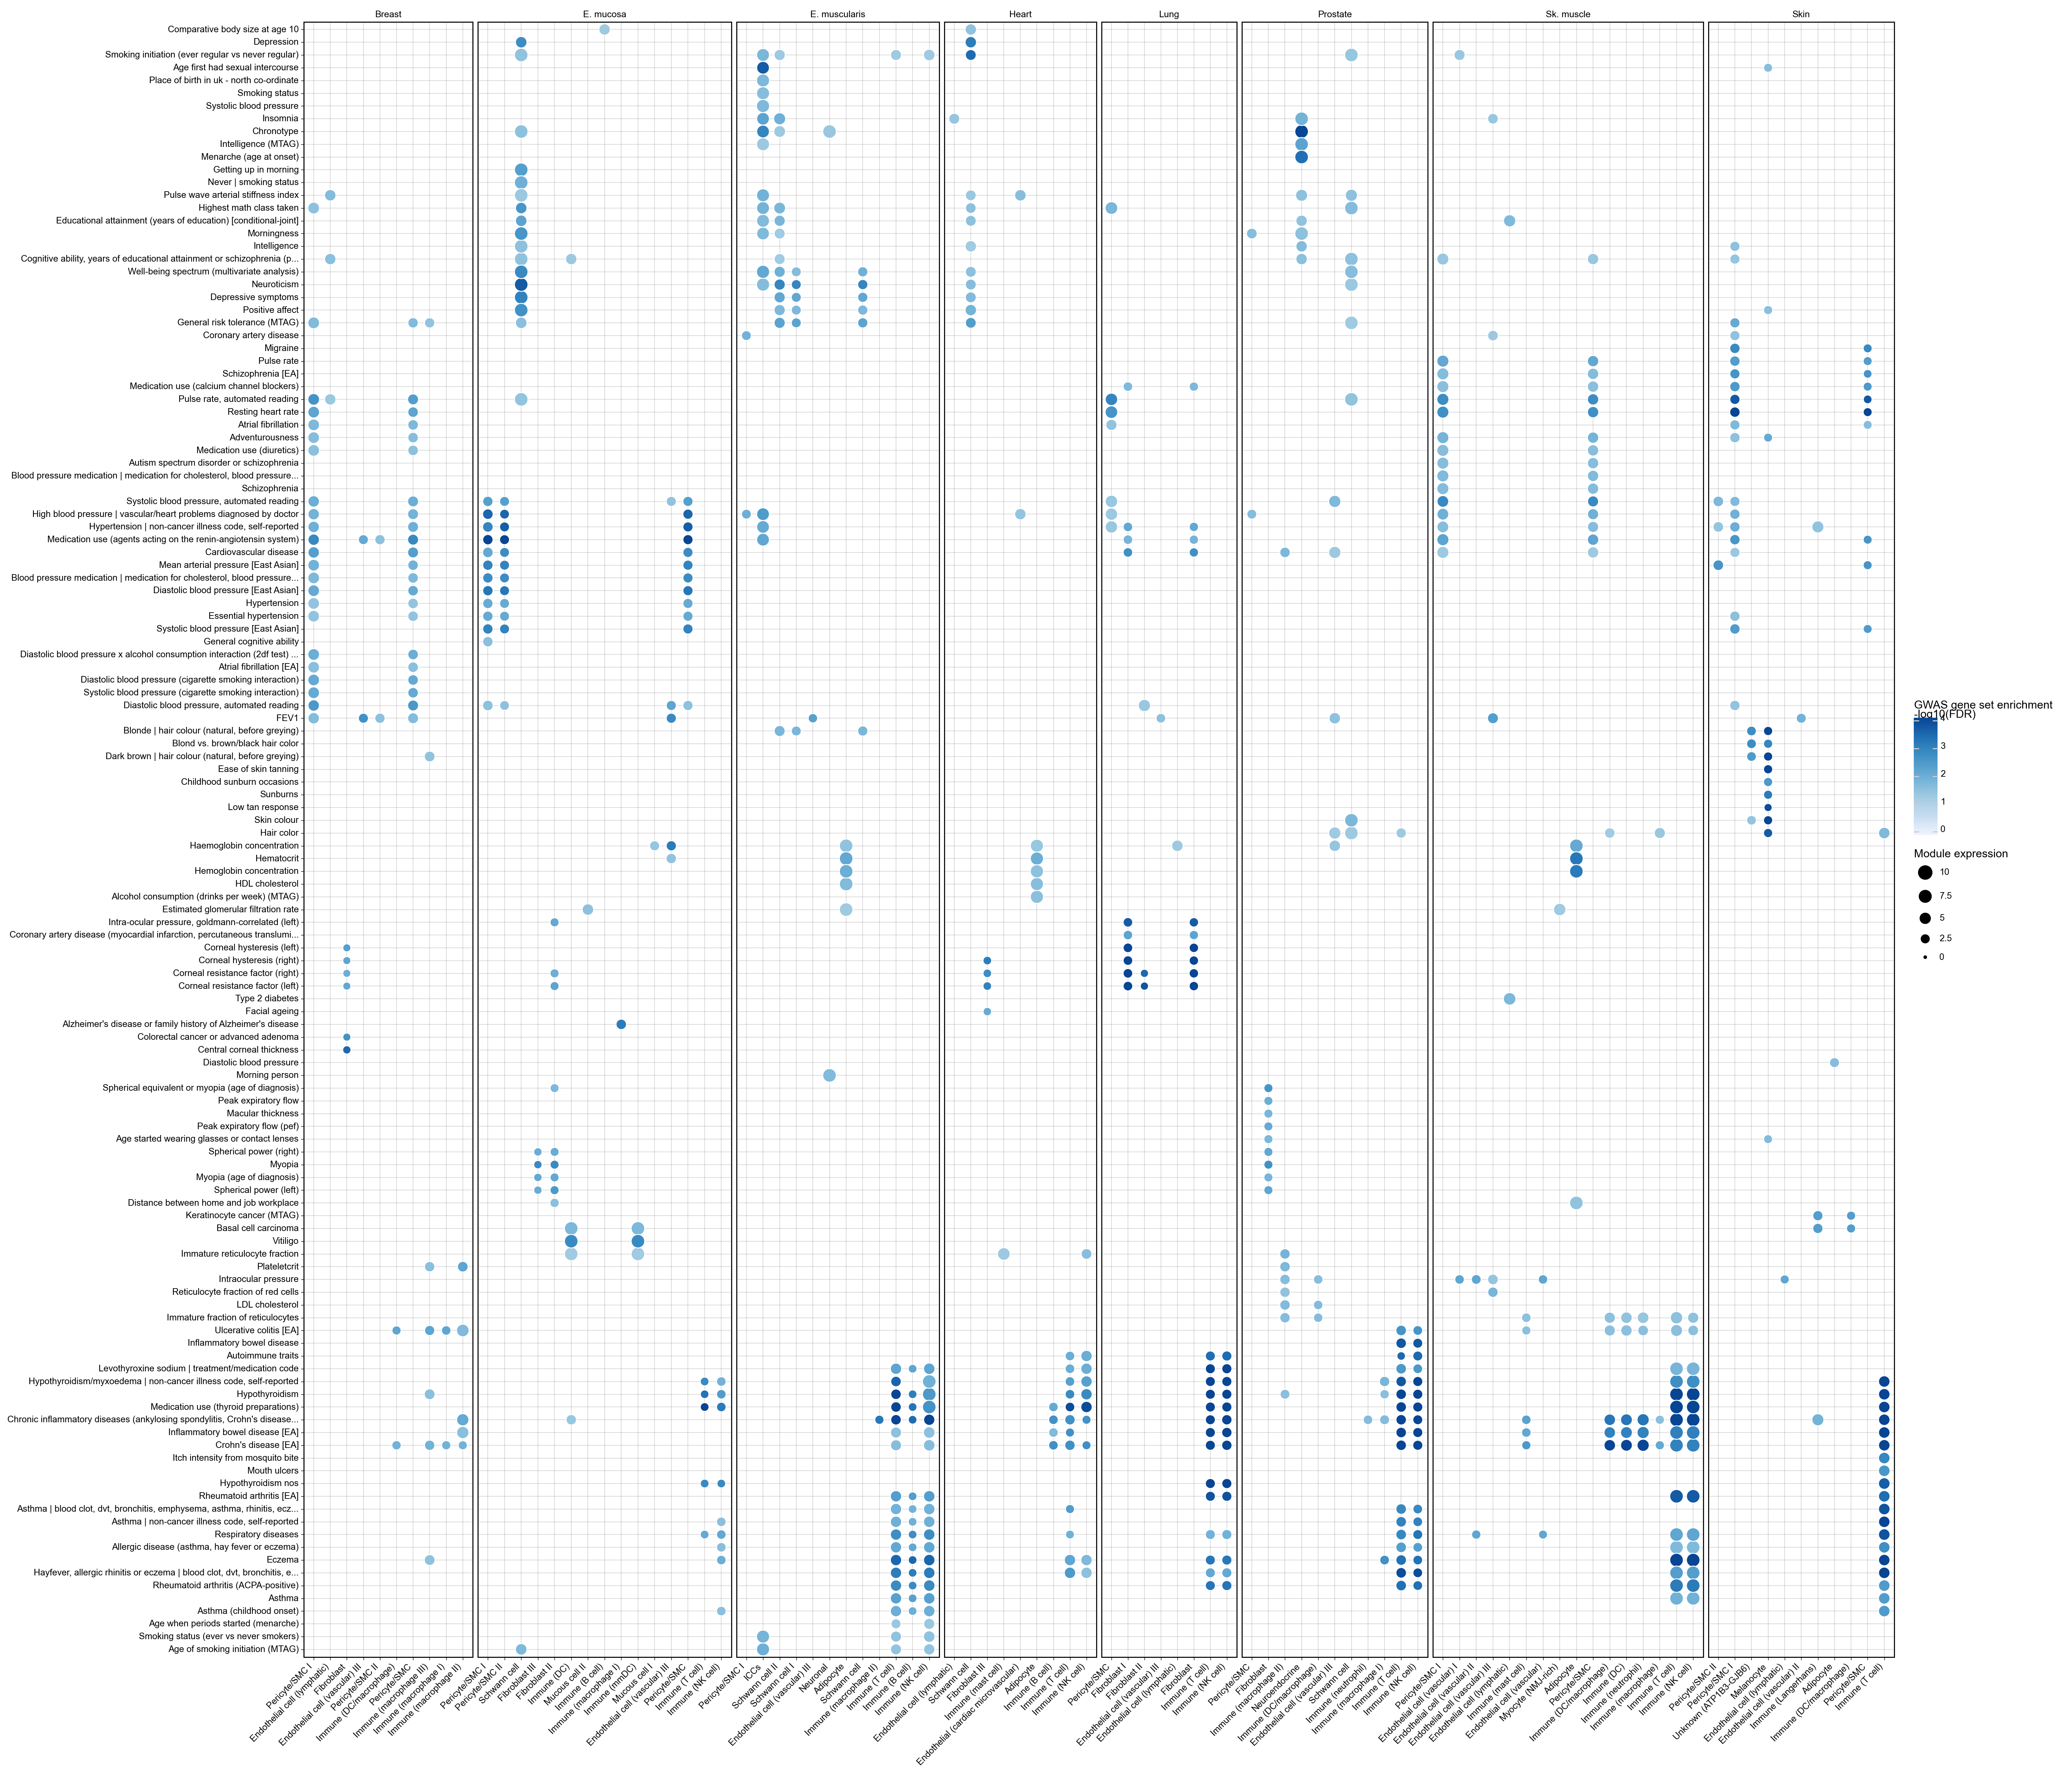

In [74]:
ctt = enrich.groupby(['celltypetissue'])['significant_expressed'].sum()>0
ctt = ctt[ctt].index

gwas_good = enrich.groupby(['gwas'])['significant_expressed'].sum()>0
gwas_good = gwas_good[gwas_good].index

levelmodule = enrich.groupby(['levelmodule'])['significant_expressed'].sum()>0
levelmodule = levelmodule[levelmodule].index

enrich = enrich[enrich.levelmodule.isin(levelmodule) & (enrich.celltypetissue.isin(ctt)) & (enrich.gwas.isin(gwas_good))]

df = enrich.copy()
df = df.loc[df[df.significant_expressed].groupby(['gwas', 'celltypetissue'])['final_score'].idxmax()].reset_index(drop=True)

#df = df[df.significant]
df['neglog_pval'] = -np.log10(df.fdr)

df['zn'] = df['neglog_pval']
df['zn'].loc[~df.significant_expressed] = -1

row_idx = sort_by_correlation(df.pivot('gwas', ['celltypetissue', 'key'], 'zn').fillna(0))
col_idx = sort_by_correlation(df.pivot('celltypetissue', ['gwas', 'key'], 'zn').fillna(0))

df['gwas'] = pd.Categorical(df.gwas, categories = np.array(sorted(df['gwas'].unique()))[row_idx])
df['celltypetissue'] = pd.Categorical(df['celltypetissue'], categories = np.array(sorted(df['celltypetissue'].unique()))[col_idx])

#df['significant'] = df.fdr_significant & df.good
#df['significant'].loc[~df['significant']] = np.nan

from plotnine import *

g = (
    ggplot(aes(x='celltypetissue', y='gwas',), data=df) +
    geom_point(aes(size='score', fill='neglog_pval'), color='white', data=df)+ #, color='#990E1D', +
    #geom_point(aes(size='score', fill='neglog_pval', color='significant_expressed'), stroke=.1, data=df[~df.significant_expressed], alpha=0.2)+ #, color='#990E1D')+
    facet_grid('~Tissue', scales='free_x', space={'x': width_scales}) + 
    scale_fill_distiller(type='seq', direction=1, limits=[0, 4], name='GWAS gene set enrichment\n-log10(FDR)') + 
    #scale_fill_cmap('BrBG_r') +
    #scale_color_manual(values=('#990E1D', '#808080'), name='significant&expressed') + 
    labs(y='', x='') +
    guides(size = guide_legend(reverse=True, override_aes = dict(fill = 'black', color='black'))) +
    theme_linedraw() +
    scale_size(range = (1,7), limits=[0,10], name='Module expression') +
    scale_x_discrete(drop=True, labels=lambda x: [i.split('|')[0] for i in x.keys()]) +
    scale_y_discrete(labels=lambda x: [i.split('_')[-1][:70] + ('...' if len(i.split('_')[-1])>70 else '') for i in x.keys()]) +    
    #scale_y_discrete(drop=False, labels=lambda x: f"{list(x.keys())[list(x.keys()).index('_')+1):50]}{'' if len(x)<50 else '...'}")
    #scale_x_discrete(drop=False) +
    #coord_cartesian(clip = 'off') +
    theme(
        strip_text_x = element_text(size=9, color='black', angle = 0),
        strip_text_y = element_text(size=9, color='black', angle = 0),      
        strip_background=element_blank(),
        text=element_text(family="Arial"),
        figure_size=(28,12*(df.gwas.nunique()/53)),
        legend_key=element_blank(),
        axis_text_x = element_text(rotation=45, hjust=1.),
    )
)
ggsave(g, sc.settings.figdir / 'SFigure-6-1.pdf', limitsize=False)
print(g)

In [40]:
import seaborn as sns

gdf = df.pivot('gwas_id', ['celltypetissue', 'key'], 'final_score').fillna(0)
cor_mat = gdf.T.corr('spearman')

In [41]:
cor_mat.index = [x.split('_')[-1] if len(x.split('_')[-1])<70 else x.split('_')[-1][:70] + '...' for x in cor_mat.index]
cor_mat.columns = [x.split('_')[-1] if len(x.split('_')[-1])<70 else x.split('_')[-1][:70] + '...' for x in cor_mat.columns]

In [ ]:
with sns.plotting_context('notebook', font_scale=.65):
    g = sns.clustermap(cor_mat, 
                       #figsize=(20,20), 
                       figsize=(30,30),                        
                       cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=True, yticklabels=True)
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    
g.savefig('figures/SFigure-6-2.pdf')

## Correlation and cell type enrichment with subset of traits

In [26]:
ordered_gwas = df.pivot('gwas_id', ['celltypetissue', 'key'], 'final_score').fillna(0).iloc[g.dendrogram_row.reordered_ind].index

In [28]:
gwas_groups = { 
    'Immune hypersensitivity': [
 'GCST001725_Inflammatory bowel disease',
 'GCST007071_Autoimmune traits',
 "GCST005537_Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) (pleiotropy) [subset analysis]",
 'GCST003043_Inflammatory bowel disease [EA]',
 "GCST003044_Crohn's disease [EA]",
 'GCST006048_Rheumatoid arthritis (ACPA-positive)',
 'NEALE2_6152_9_Hayfever, allergic rhinitis or eczema | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
 'GCST007076_Respiratory diseases',
 'GCST007932_Medication use (thyroid preparations)',
 'NEALE2_20002_1226_Hypothyroidism/myxoedema | non-cancer illness code, self-reported',
 'GCST007073_Hypothyroidism',
 'GCST007075_Eczema',
 'GCST005038_Allergic disease (asthma, hay fever or eczema)',
 'NEALE2_6152_8_Asthma | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
    ],
    'Cardiovascular': [
 'NEALE2_4079_raw_Diastolic blood pressure, automated reading',
 'GCST007706_2_Mean arterial pressure [East Asian]',
 'NEALE2_6150_4_High blood pressure | vascular/heart problems diagnosed by doctor',
 'GCST007930_Medication use (agents acting on the renin-angiotensin system)',
 'GCST007072_Cardiovascular disease',
    ],    
    'Ca channel-related': 
    [
 'GCST004521_Autism spectrum disorder or schizophrenia',
 'GCST006803_Schizophrenia',
 'GCST007929_Medication use (calcium channel blockers)',
 'GCST007201_2_Schizophrenia [EA]',
 'NEALE2_4194_raw_Pulse rate',
    ],    
    'Cognitive/psychiatric':  [
 'GCST008595_Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)',
 'GCST007325_General risk tolerance (MTAG)',
 'GCST006442_2_Educational attainment (years of education) [conditional-joint]',
 'GCST007576_Chronotype',
 'GCST007983_Morningness',
 'GCST006574_Highest math class taken',
 'GCST007339_Neuroticism',
 'GCST006250_Intelligence',
 'NEALE2_1170_Getting up in morning',
    ],
    'Skin/hair color': 
    [
 'GCST005897_Low tan response',
 'NEALE2_1717_Skin colour',
 'GCST006988_Blond vs. brown/black hair color',
    ],
    'Hemoglobin/HDL': [
        'GCST004604_Hematocrit',
        'GCST004615_Hemoglobin concentration',
        'GCST006611_HDL cholesterol',
    ],
}

In [29]:
gwas_labels = [y for x in list(gwas_groups.values()) for y in x]

In [30]:
gwas_labels

['GCST001725_Inflammatory bowel disease',
 'GCST007071_Autoimmune traits',
 "GCST005537_Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) (pleiotropy) [subset analysis]",
 'GCST003043_Inflammatory bowel disease [EA]',
 "GCST003044_Crohn's disease [EA]",
 'GCST006048_Rheumatoid arthritis (ACPA-positive)',
 'NEALE2_6152_9_Hayfever, allergic rhinitis or eczema | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
 'GCST007076_Respiratory diseases',
 'GCST007932_Medication use (thyroid preparations)',
 'NEALE2_20002_1226_Hypothyroidism/myxoedema | non-cancer illness code, self-reported',
 'GCST007073_Hypothyroidism',
 'GCST007075_Eczema',
 'GCST005038_Allergic disease (asthma, hay fever or eczema)',
 'NEALE2_6152_8_Asthma | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
 'NEALE2_4079_raw_Diastolic blood pressure, a

In [31]:
gwas_label_short_candidate = [x.split('_')[-1].replace('East Asian', 'EA').replace(', automated reading', '') + (' [UKBB]' if "NEALE" in x else '') for x in gwas_labels]
gwas_label_short_candidate

['Inflammatory bowel disease',
 'Autoimmune traits',
 "Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) (pleiotropy) [subset analysis]",
 'Inflammatory bowel disease [EA]',
 "Crohn's disease [EA]",
 'Rheumatoid arthritis (ACPA-positive)',
 'Hayfever, allergic rhinitis or eczema | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor [UKBB]',
 'Respiratory diseases',
 'Medication use (thyroid preparations)',
 'Hypothyroidism/myxoedema | non-cancer illness code, self-reported [UKBB]',
 'Hypothyroidism',
 'Eczema',
 'Allergic disease (asthma, hay fever or eczema)',
 'Asthma | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor [UKBB]',
 'Diastolic blood pressure [UKBB]',
 'Mean arterial pressure [EA]',
 'High blood pressure | vascular/heart problems diagnosed by doctor [UKBB]',
 'Medication use (agents acting on the renin-a

In [32]:
gwas2short = {
 'NEALE2_4079_raw_Diastolic blood pressure, automated reading': 'Diastolic blood pressure [UKBB]',
 'SAIGE_401_1_Essential hypertension': 'Essential hypertension',
 'GCST007706_2_Mean arterial pressure [East Asian]': 'Mean arterial pressure [EA]',
 'SAIGE_401_Hypertension': 'Hypertension',
 'NEALE2_6177_2_Blood pressure medication | medication for cholesterol, blood pressure or diabetes': 'Blood pressure medication [UKBB]',
 'GCST006414_Atrial fibrillation': 'Atrial fibrillation',
 'NEALE2_6150_4_High blood pressure | vascular/heart problems diagnosed by doctor': 'High blood pressure [UKBB]',
 'GCST007930_Medication use (agents acting on the renin-angiotensin system)': 'Medication use (renin-angiotensin sys.)',
 'GCST007072_Cardiovascular disease': 'Cardiovascular disease',
 'NEALE2_4080_raw_Systolic blood pressure, automated reading': 'Systolic blood pressure [UKBB]',
 'GCST003818_Resting heart rate': 'Resting heart rate',
 'GCST007928_Medication use (diuretics)': 'Medication use (diuretics)',
 'GCST001725_Inflammatory bowel disease': 'Inflammatory bowel disease',
 'GCST007071_Autoimmune traits': 'Autoimmune traits',
 "GCST005537_Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) (pleiotropy) [subset analysis]": 'Chronic inflammatory diseases',
 'GCST003043_Inflammatory bowel disease [EA]': 'Inflammatory bowel disease [EA]',
 "GCST003044_Crohn's disease [EA]": "Crohn's disease [EA]",
 'NEALE2_20003_1141191044_Levothyroxine sodium | treatment/medication code': 'Levothyroxine sodium [UKBB]',
 'GCST006048_Rheumatoid arthritis (ACPA-positive)': 'Rheumatoid arthritis (ACPA-positive)',
 'NEALE2_6152_9_Hayfever, allergic rhinitis or eczema | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor': 'Hayfever, allergic rhinitis or eczema [UKBB]',
 'GCST007076_Respiratory diseases': 'Respiratory diseases',
 'GCST007932_Medication use (thyroid preparations)': 'Medication use (thyroid preparations)',
 'NEALE2_20002_1226_Hypothyroidism/myxoedema | non-cancer illness code, self-reported': 'Hypothyroidism/myxoedema [UKBB]',
 'GCST007073_Hypothyroidism': 'Hypothyroidism',
 'GCST007075_Eczema': 'Eczema',
 'GCST007800_Asthma (childhood onset)': 'Asthma (childhood onset)',
 'GCST005038_Allergic disease (asthma, hay fever or eczema)': 'Allergic disease',
 'NEALE2_6152_8_Asthma | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor': 'Asthma [UKBB]',
 'GCST008595_Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)': 'Cognitive ability',
 'GCST007325_General risk tolerance (MTAG)': 'General risk tolerance',
 'GCST006442_2_Educational attainment (years of education) [conditional-joint]': 'Educational attainment',
 'GCST007576_Chronotype': 'Chronotype',
 'GCST007983_Morningness': 'Morningness',
 'GCST006574_Highest math class taken': 'Highest math class taken',
 'GCST007339_Neuroticism': 'Neuroticism',
 'GCST007341_Well-being spectrum (multivariate analysis)': 'Well-being spectrum',
 'GCST007340_Depressive symptoms': 'Depressive symptoms',
 'GCST006250_Intelligence': 'Intelligence',
 'GCST007342_Depression': 'Depression',
 'NEALE2_1170_Getting up in morning': 'Getting up in morning [UKBB]',
 'NEALE2_1737_Childhood sunburn occasions': 'Childhood sunburn occasions [UKBB]',
 'NEALE2_1727_Ease of skin tanning': 'Ease of skin tanning [UKBB]',
 'GCST005897_Low tan response': 'Low tan response',
 'GCST007086_Sunburns': 'Sunburns',
 'NEALE2_1717_Skin colour': 'Skin colour [UKBB]',
 'GCST006988_Blond vs. brown/black hair color': 'Blond vs. brown/black hair color',
 'NEALE2_6153_2_Blood pressure medication | medication for cholesterol, blood pressure, diabetes, or take exogenous hormones': 'Blood pressure medication [UKBB]',
 'GCST004521_Autism spectrum disorder or schizophrenia': 'Autism spectrum disorder or SCZ',
 'GCST006803_Schizophrenia': 'Schizophrenia',
 'GCST007929_Medication use (calcium channel blockers)': 'Medication use (Ca channel blockers)',
 'GCST007201_2_Schizophrenia [EA]': 'Schizophrenia [EA]',
 'NEALE2_4194_raw_Pulse rate': 'Pulse rate [UKBB]',
 'GCST004604_Hematocrit': 'Hematocrit',
 'GCST004615_Hemoglobin concentration': 'Hemoglobin concentration',
 'GCST006611_HDL cholesterol': 'HDL cholesterol',
}

In [33]:
gwas_labels_short = [gwas2short[x] for x in gwas_labels]

In [34]:
corrmat = gdf.T.corr('spearman')

In [ ]:
with sns.plotting_context('notebook', font_scale=1.):
    temp_df = corrmat.loc[gwas_labels,gwas_labels]
    #temp_df.index = [id2text[x][:50]+'...' if len(id2text[x])>50 else id2text[x] for x in temp_df.index]
    temp_df.index = gwas_labels_short
    temp_df.columns = gwas_labels_short    
    #temp_df.columns = [id2text[x][:50]+'...' if len(id2text[x])>50 else id2text[x] for x in temp_df.columns]
    g = sns.clustermap(temp_df, figsize=(len(gwas_labels)*0.3,len(gwas_labels)*0.24),
                       cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=False, yticklabels=True)
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    
g.savefig('figures/Figure-6B-colorbar.pdf')

In [36]:
ordered_gwas_labels = np.array(gwas_labels)[g.dendrogram_row.reordered_ind].tolist()
ordered_gwas_labels_short = np.array(gwas_labels_short)[g.dendrogram_row.reordered_ind].tolist()

In [37]:
ordered_gwas_labels

["GCST005537_Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) (pleiotropy) [subset analysis]",
 'GCST003043_Inflammatory bowel disease [EA]',
 "GCST003044_Crohn's disease [EA]",
 'NEALE2_20002_1226_Hypothyroidism/myxoedema | non-cancer illness code, self-reported',
 'GCST007073_Hypothyroidism',
 'GCST007075_Eczema',
 'NEALE2_6152_9_Hayfever, allergic rhinitis or eczema | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
 'GCST007932_Medication use (thyroid preparations)',
 'GCST006048_Rheumatoid arthritis (ACPA-positive)',
 'GCST007076_Respiratory diseases',
 'GCST005038_Allergic disease (asthma, hay fever or eczema)',
 'NEALE2_6152_8_Asthma | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
 'GCST001725_Inflammatory bowel disease',
 'GCST007071_Autoimmune traits',
 'GCST004521_Autism spectrum disorder or schi

In [38]:
ordered_gwas_labels = [  
 'GCST001725_Inflammatory bowel disease',
 'GCST007071_Autoimmune traits',
 "GCST005537_Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) (pleiotropy) [subset analysis]",
 "GCST003044_Crohn's disease [EA]",
 'GCST006048_Rheumatoid arthritis (ACPA-positive)',
 'GCST007076_Respiratory diseases',
 'GCST007932_Medication use (thyroid preparations)',
 'NEALE2_20002_1226_Hypothyroidism/myxoedema | non-cancer illness code, self-reported',
 'GCST007073_Hypothyroidism',
 'GCST007075_Eczema',
 'NEALE2_6152_9_Hayfever, allergic rhinitis or eczema | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',
 'GCST005038_Allergic disease (asthma, hay fever or eczema)',
 'NEALE2_6152_8_Asthma | blood clot, dvt, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor',     
 'NEALE2_4079_raw_Diastolic blood pressure, automated reading',
 'GCST007072_Cardiovascular disease',
 'NEALE2_6150_4_High blood pressure | vascular/heart problems diagnosed by doctor',
 'GCST007930_Medication use (agents acting on the renin-angiotensin system)',
 'GCST004521_Autism spectrum disorder or schizophrenia',
 'GCST007929_Medication use (calcium channel blockers)',
 'NEALE2_4194_raw_Pulse rate',        
 'GCST006803_Schizophrenia',   
 'GCST008595_Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)',
 'GCST007325_General risk tolerance (MTAG)',
 'GCST006574_Highest math class taken',
 'GCST006250_Intelligence',    
 'GCST006442_2_Educational attainment (years of education) [conditional-joint]',
 'GCST007576_Chronotype',
 'GCST007983_Morningness',
 'NEALE2_1170_Getting up in morning',
 'GCST007339_Neuroticism',
 'NEALE2_1717_Skin colour',    
 'GCST005897_Low tan response',
 'GCST006988_Blond vs. brown/black hair color',    
 'GCST006611_HDL cholesterol',
 'GCST004604_Hematocrit',
 'GCST004615_Hemoglobin concentration',
]

In [39]:
ordered_gwas_labels_short = [gwas2short[x] for x in ordered_gwas_labels]

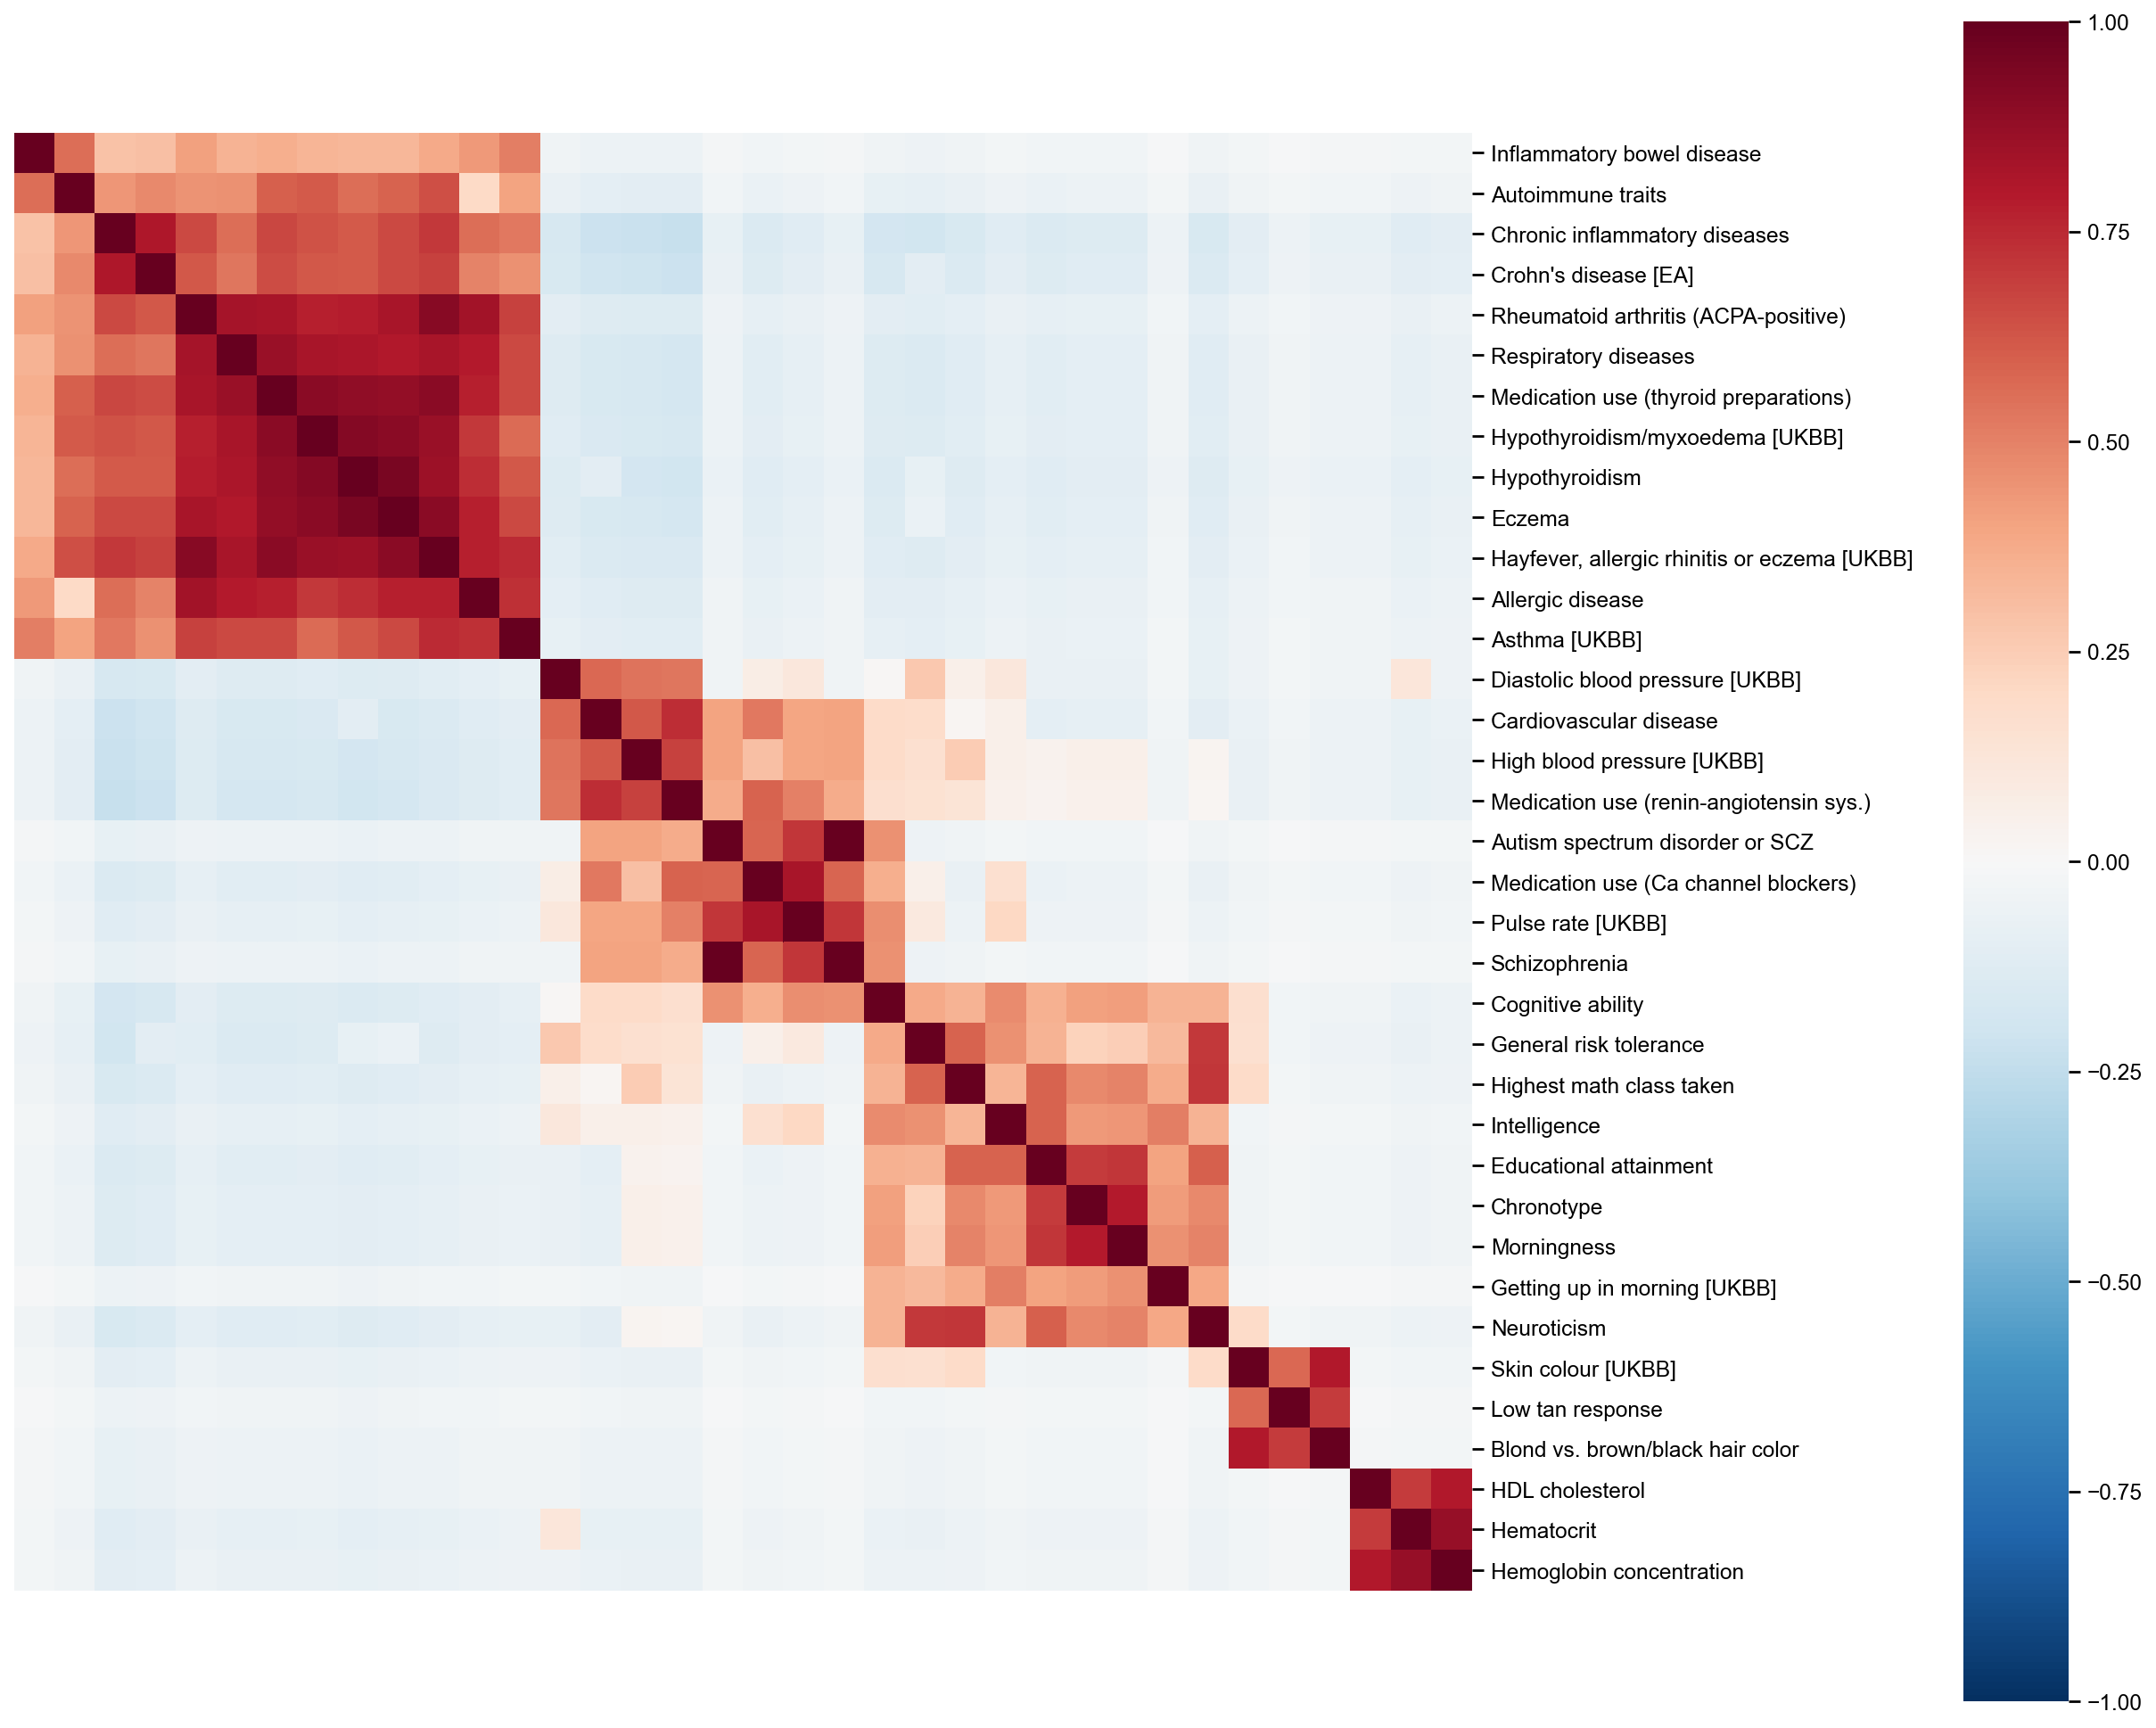

In [40]:
import matplotlib.pyplot as plt

with sns.plotting_context('notebook', font_scale=1.):
    temp_df = corrmat.loc[ordered_gwas_labels,ordered_gwas_labels]
    temp_df.index = ordered_gwas_labels_short
    temp_df.columns = ordered_gwas_labels_short    
    fig, ax = plt.subplots(figsize=(15,12), constrained_layout=True)
    sns.heatmap(temp_df,
                cmap='RdBu_r',
                vmin=-1,
                square=True,
                vmax=1,
                xticklabels=False, 
                ax=ax,
                yticklabels=True)
ax.tick_params(right=True, left=False, labelleft=False, labelright=True, rotation=0)    

fig.savefig('figures/Figure-6B.pdf', bbox_inches='tight')

In [42]:
ggs = []

df = enrich.copy()

for title, gwas_group in gwas_groups.items():
    #dd = df[(df.gwas_id.isin(gwas_group)) & (df.key == 'Granular cell type')].copy()
    dd = df[(df.gwas_id.isin(gwas_group)) & (df.key == 'Broad cell type')].copy()
    #dd = df[(df.gwas_id.isin(gwas_group))].copy()    
    
    #dd = dd.loc[dd.groupby(['gwas', 'celltypetissue'])['final_score'].idxmax()].reset_index(drop=True)
    dd['neglog_pval'] = -np.log10(dd.fdr)
    
    dd.neglog_pval *= dd.significant_expressed
    dd.score *= dd.significant_expressed
    dd.zscore *= dd.significant_expressed    
    
    gg1 = dd.groupby(['category', 'tissue', 'Tissue', 'celltypetissue'], observed=True)[['score', 'neglog_pval', 'fscore']].mean().reset_index()
    gg1['finalscore'] = gg1.score * gg1.fscore
    gg1 = gg1.sort_values('finalscore', ascending=False)
    gg1['celltypetissue'] = gg1.category.astype(str) + '\n' + gg1.tissue.astype(str)
    gg1.celltypetissue = pd.Categorical(gg1.celltypetissue, categories=gg1.celltypetissue[::-1])
    gg1['label'] = gg1.category.astype(str) + ' - ' + gg1.Tissue.astype(str) + '_' + title
    
    ggs.append(gg1.assign(group=title)[:7])
    #g = ggplot(aes(y='finalscore', x='celltypetissue'), gg1[:10]) + geom_bar(stat='identity') + coord_flip() + theme_minimal() + labs(y='Weighted module expression', x='Cell type', title=title) + theme(figure_size=(3,4))
    #print(g)

In [43]:
ggs = pd.concat(ggs, axis=0)

In [ ]:
ggs['label'] = pd.Categorical(ggs.label, categories=ggs.label.values.astype(str))
ggs['group'] = pd.Categorical(ggs['group'], categories=gwas_groups.keys())

g = (
    ggplot(aes(y='finalscore', x='label'), ggs) + 
    geom_bar(stat='identity', width=0.5) + 
    #coord_flip() + 
    facet_wrap('group', scales='free', nrow=1) + 
    #scale_fill_manual(colormap) +
    scale_x_discrete(drop=True, labels=lambda x: [i.split('_')[0] for i in x.keys()]) +    
    scale_y_continuous(expand = (0, 0, 0.05, 0)) +    
    labs(y='Cell type\nenrichment score', x='', fill='Cell type') + 
    theme_bw() +     
    theme(
        text=element_text(family="Arial"),        
        figure_size=(13,2), 
        panel_spacing_x=0.6,
        panel_grid=element_blank(), strip_background=element_blank(),
        axis_text_x=element_text(rotation=90),
    )
)

ggsave(g, 'figures/Figure-6C.pdf')

g

In [46]:
pd.options.display.max_columns = 40

In [49]:
go = enrich[enrich.gwas_id.isin(gwas_labels) & enrich.significant_expressed].groupby(['gwas_id', 'gwas'], sort=False, as_index=False).intersections.agg(lambda x: list(set([i for y in x for i in y]))).set_index('gwas_id').loc[ordered_gwas_labels].reset_index()
go.head(20)

,gwas_id,gwas,intersections
0,GCST001725_Inflammatory bowel disease,Inflammatory bowel disease,"[IKZF1, PTGER4, CD226, STAT4, PRDM1, IL12RB2, ..."
1,GCST007071_Autoimmune traits,Autoimmune traits,"[CD226, STAT4, SH2D2A, ZAP70, PTPN22, RASGRP1,..."
2,GCST005537_Chronic inflammatory diseases (anky...,Chronic inflammatory diseases (ankylosing spon...,"[RIPK2, MAP3K8, IL27, PRDM1, ANKRD55, ZPBP2, R..."
3,GCST003044_Crohn's disease [EA],Crohn's disease [EA],"[MAP3K8, IL27, PRDM1, ZFP36L2, ANKRD55, ZPBP2,..."
4,GCST006048_Rheumatoid arthritis (ACPA-positive),Rheumatoid arthritis (ACPA-positive),"[UBASH3A, TAGAP, ETS1, STAT4, ANKRD55, PTPN22,..."
5,GCST007076_Respiratory diseases,Respiratory diseases,"[IL7R, ITK, SPATA32, CD247, ID2, PRKCQ, ITPKB,..."
6,GCST007932_Medication use (thyroid preparations),Medication use (thyroid preparations),"[ITK, PRKCQ, IL2RA, JAK1, ARID5B, IL7R, UBASH3..."
7,NEALE2_20002_1226_Hypothyroidism/myxoedema | n...,Hypothyroidism/myxoedema | non-cancer illness ...,"[RUNX3, CD86, MYB, IL2RA, ARID5B, CTLA4, CBLB,..."
8,GCST007073_Hypothyroidism,Hypothyroidism,"[RUNX3, IL2RA, MB21D2, JAK1, ARID5B, IL7R, UBA..."
9,GCST007075_Eczema,Eczema,"[ASCL2, PRKCQ, GSAP, RUNX3, IL2RA, TNFAIP8, IL..."


## GO enrichment

In [50]:
go_set = go.set_index('gwas')['intersections'].to_dict()

In [51]:
label_dict = {}

for k,v in gwas_groups.items():
    for i in v:
        label_dict[i] = k

In [52]:
pd.options.display.max_colwidth = None

In [ ]:
go['gwas_group'] = go.gwas_id.map(label_dict)

In [54]:
gwas_group_genes = go.explode('intersections').groupby('gwas_group', sort=False)['intersections'].agg(list).to_dict()

In [55]:
go_gene_freq = go.explode('intersections').value_counts(['gwas_group', 'intersections']).reset_index().sort_values(['gwas_group', 0], ascending=[True, False]).rename(columns={0: 'freq'})
go_gene_freq

,gwas_group,intersections,freq
57,Ca channel-related,CACNA1C,3
67,Ca channel-related,RGS6,3
74,Ca channel-related,CACNB2,3
156,Ca channel-related,ITIH3,2
290,Ca channel-related,TCF21,1
...,...,...,...
197,Skin/hair color,PKHD1,1
200,Skin/hair color,CREB5,1
211,Skin/hair color,CKB,1
226,Skin/hair color,CADM2,1


In [56]:
markers = go_gene_freq.loc[go_gene_freq.groupby('gwas_group').freq.head(15).index].groupby('gwas_group').intersections.agg(list)
markers

gwas_group
Ca channel-related                  [CACNA1C, RGS6, CACNB2, ITIH3, TCF21, TAGLN, SPEG, PLN, PLCE1, PALLD, NPNT, NGF, MYH11, JPH2, JAG1]
Cardiovascular                   [PDE3A, SOX6, JAG1, PLCE1, ENPEP, CACNB2, ARHGAP42, NPNT, RGL3, TBX2, WNT2B, NGF, CACNA1D, CHDH, EBF2]
Cognitive/psychiatric         [CADM2, NRXN1, SORCS3, NEGR1, KIRREL3, PCDH9, CDH2, NCAM1, LRRTM4, ELAVL2, CADM3, CNTN4, CDH8, FIGN, AK5]
Hemoglobin/HDL             [PNPLA3, PPARG, PCK1, DGAT2, ADCY6, ACO1, PDE8B, PLIN4, SMAD7, SLC7A10, NUP160, ANGPTL8, ATP2B4, GCKR, GJA5]
Immune hypersensitivity      [IL2RA, CD247, ID2, STAT4, IL7R, RASGRP1, PTPN22, CD226, ETS1, RUNX3, GATA3, THEMIS, IL18R1, IKZF1, PRKCQ]
Skin/hair color                     [BNC2, TYRP1, TYR, SIK1, OCA2, ATP1B3, FOSL2, DCT, SOX6, KIAA0930, MLANA, MITF, FOXD3, TPCN2, IRF4]
Name: intersections, dtype: object

set(gwas_group_genes['SCZ/ASD/Pulse rate']) & set(gwas_group_genes['Cardiovascular']) & set(gwas_group_genes['Cognitive/psychiatric'])

set(gwas_group_genes['SCZ/ASD/Pulse rate']) & set(gwas_group_genes['Cognitive/psychiatric'])

In [57]:
%matplotlib inline

Immune hypersensitivity
Cardiovascular
Ca channel-related
Cognitive/psychiatric
Skin/hair color
Hemoglobin/HDL


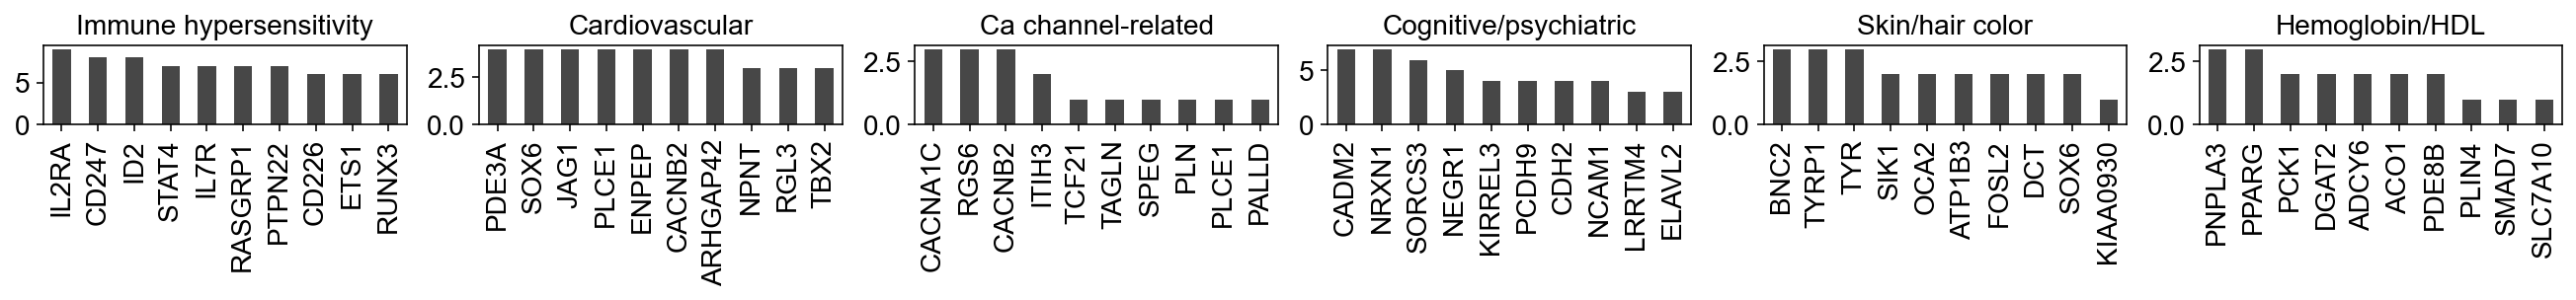

In [67]:
f, axs = plt.subplots(1, len(gwas_groups), figsize=(18, 2), constrained_layout=True)
axs = axs.flatten()

for group, ax in zip(go['gwas_group'].unique(), axs):
    print(group)
    inf_genes = go_gene_freq[go_gene_freq.gwas_group == group].head(10)
    p = inf_genes.plot('intersections', 'freq', kind='bar', grid=False, color='#474747', rot=90, ax=ax, legend=False, xlabel='')
    ax.set_title(group)

f.show()

In [68]:
f.savefig('figures/Figure-6E.pdf')

In [69]:
sc.set_figure_params(dpi=100)

In [74]:
%%time

res = sc.queries.enrich(go_set, gprofiler_kwargs={'no_evidences': False, 'all_results': True, 'sources': ['GO:BP', 'REAC']})
res['name'] = [x[0].upper() + x[1:] for x in res['name']]
res['query'] = pd.Categorical(res['query'], categories=list(go_set.keys()))

CPU times: user 2.81 s, sys: 133 ms, total: 2.95 s
Wall time: 19.3 s


In [76]:
res['fscore'] = 2*res.precision*res.recall/(res.precision+res.recall)
res['neglogpval'] = -np.log10(res.p_value)
res['significant'] = res.p_value < 0.1

In [77]:
res = res.loc[res.groupby(['name', 'query'], observed=True, sort=False).p_value.idxmin().values]

In [82]:
pathway_sheet = pd.read_excel('GTEx Fig6 pathways.xlsx').fillna('')
#pathway_sheet = pathway_sheet[pathway_sheet.show=='x']
go_order = pathway_sheet['GO/REAC term'].values
go_order_subset = pathway_sheet[pathway_sheet['show v2']=='x']['GO/REAC term'].values

In [ ]:
res = res.set_index('name').loc[go_order].reset_index()

In [84]:
remove = res.groupby('native').significant.sum()==0
remove = remove[remove].index

res = res[~res.native.isin(remove)].copy().reset_index(drop=True)

In [90]:
idx = sort_by_correlation(res.pivot('name', 'query', 'neglogpval').fillna(0))
names = res.pivot('name', 'query', 'neglogpval').index

In [93]:
res['name'] = pd.Categorical(res.name, categories=go_order)
res['query'] = pd.Categorical(res['query'], categories=list(go_set.keys())[::-1])

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10.5 x 9 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/Figure-6D.pdf


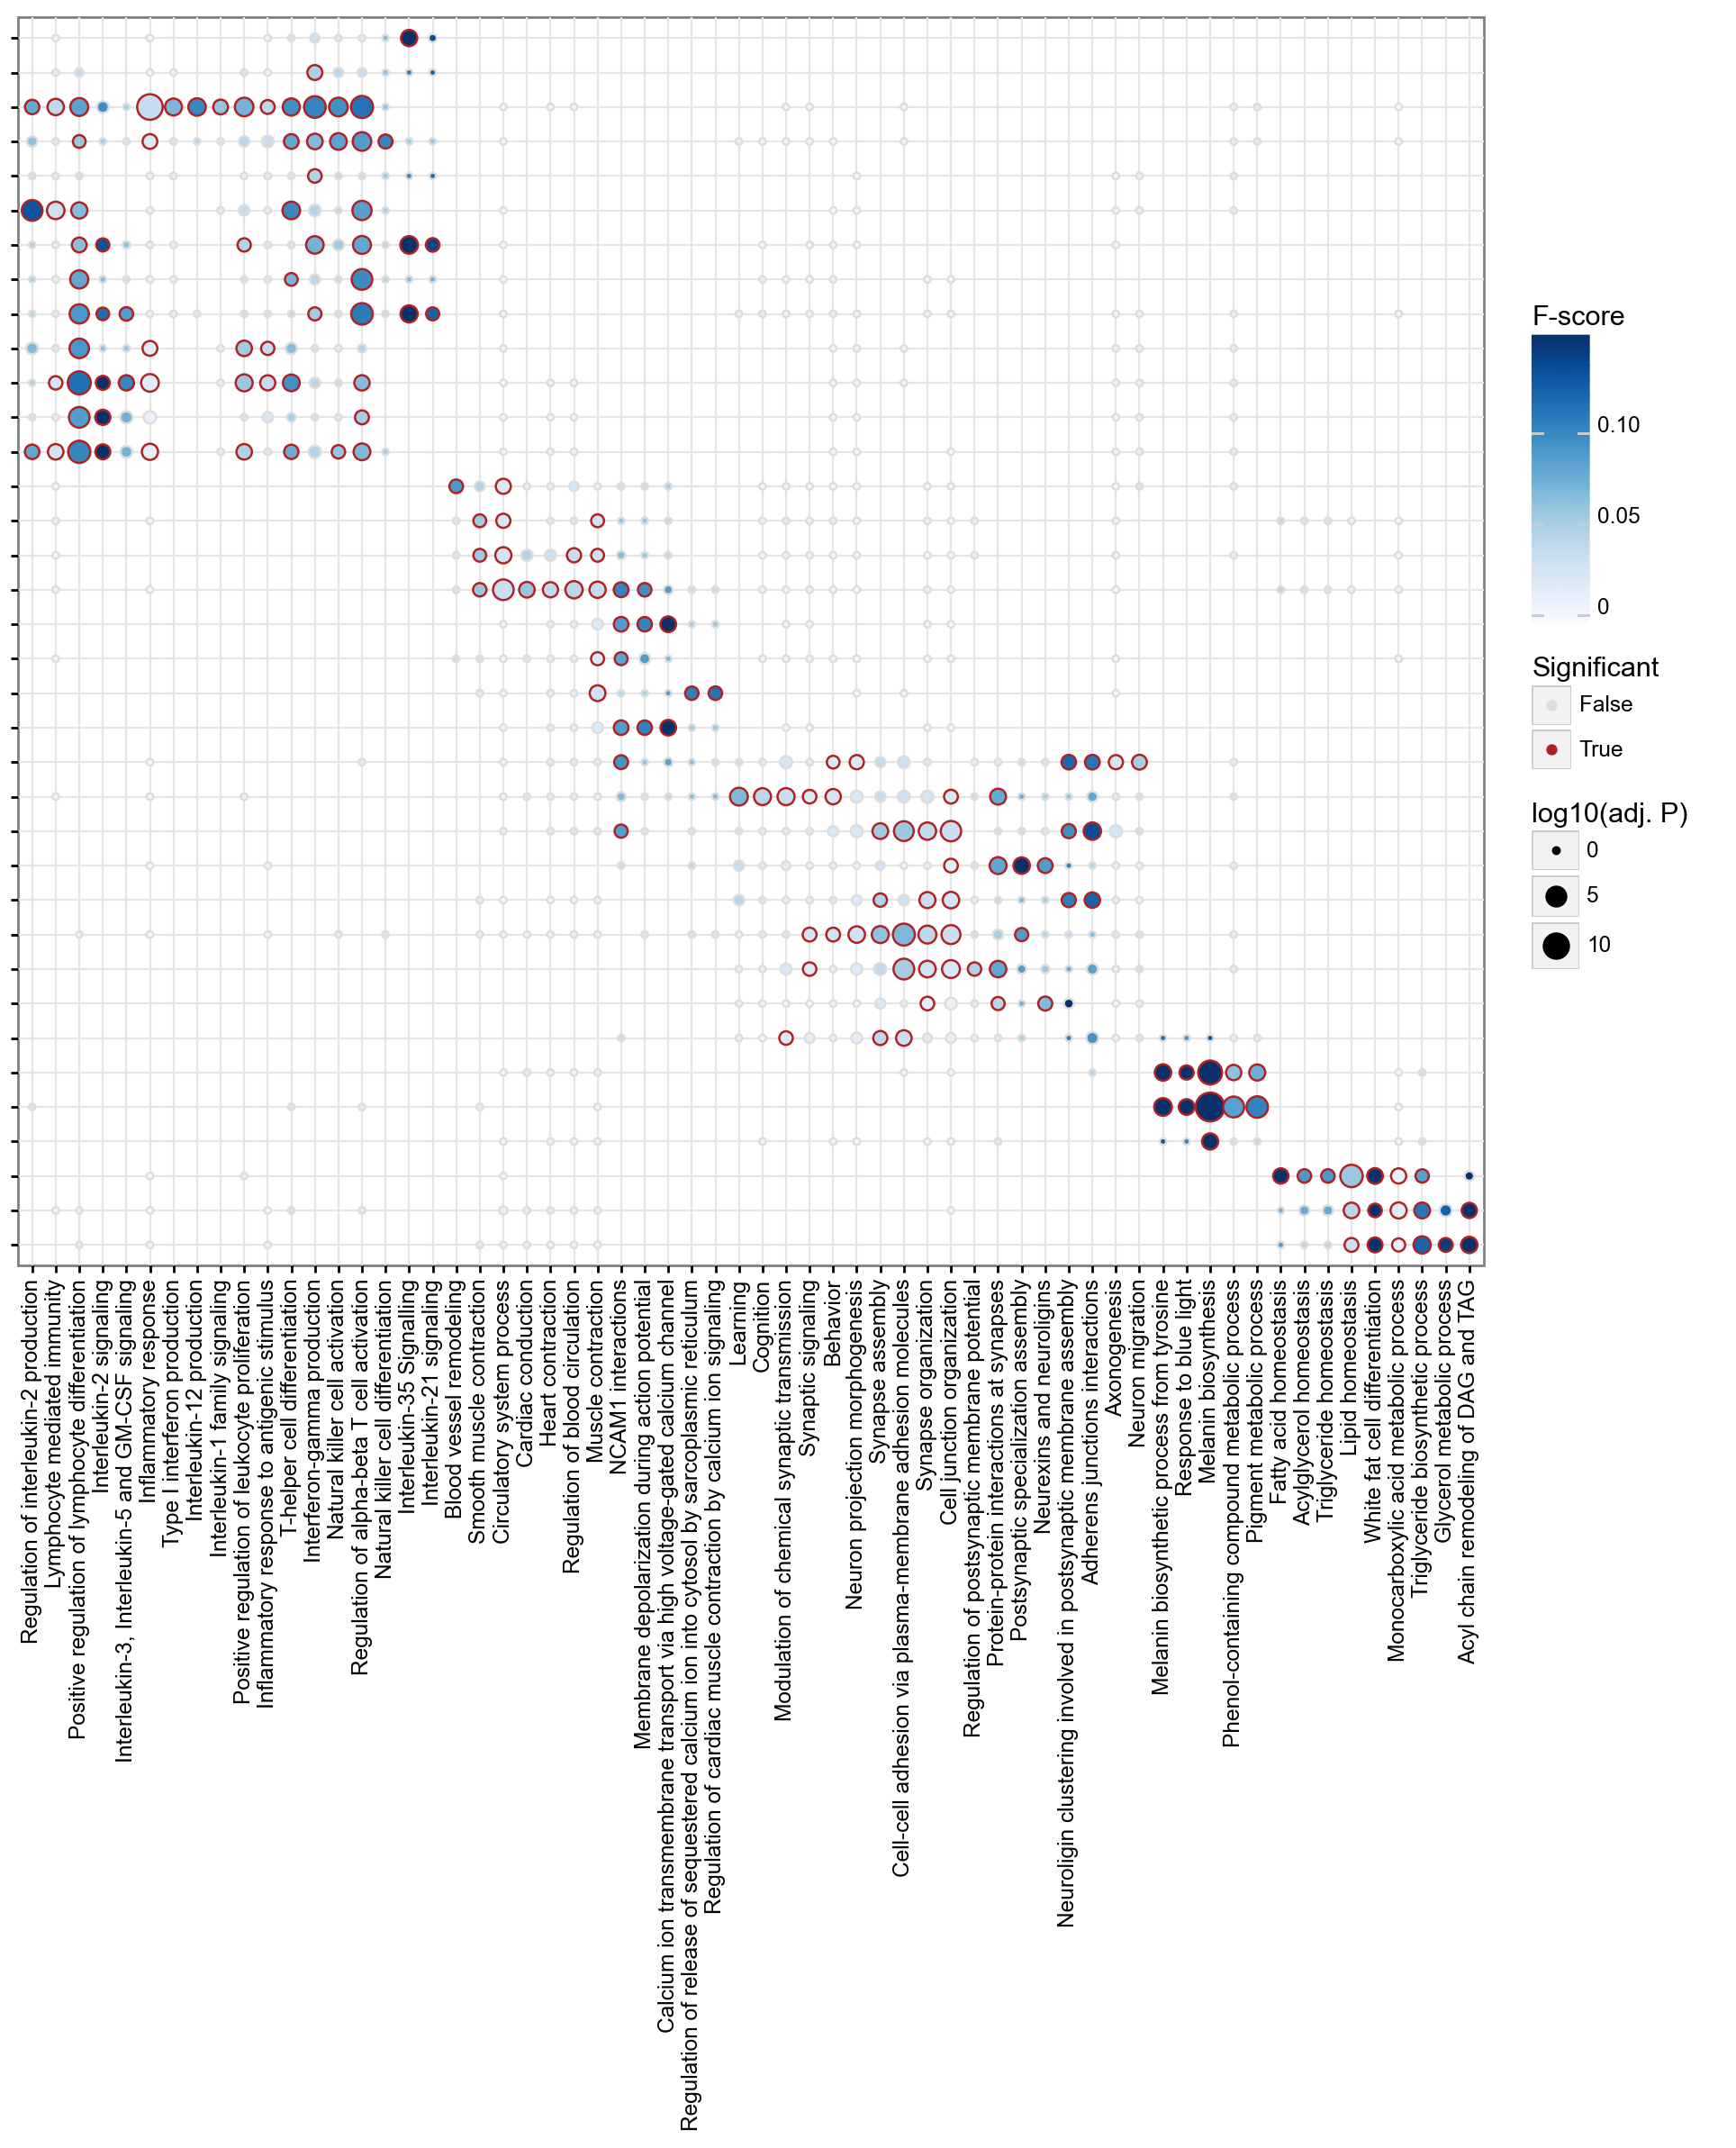

In [99]:
g = (
    ggplot(aes(x='name', y='query'), data=res[res.name.isin(go_order_subset)]) + 
    geom_point(aes(size='neglogpval', fill='fscore', color='significant')) + 
    scale_fill_cmap('Blues', limits=[0, 0.15]) +
    scale_color_manual(values={True: '#AF2122', False:'#dddddd'}) + 
    theme_bw() + 
    labs(x='', y='', color='Significant', fill='F-score', size='log10(adj. P)') +
    theme(
        text=element_text(family="Arial", color='black'),
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        figure_size=(10.5,9), 
        axis_text_y=element_blank(),
    )
)

ggsave(g, 'figures/Figure-6D.pdf', limitsize=False)

print(g)